<a href="https://colab.research.google.com/github/rhysdavies21/library/blob/master/rate_derivatives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ZC Bond Calculator

def zero_coupon_bond(par, y, t):
  '''
  Price of a zero coupon bond
  
  : param par: face value of bond
  : param y: annual yield or rate of the bond:
  : param t: time to maturity, in years
  '''
  return par / (1+y)**t

In [2]:
# Price ZC Bond

print(zero_coupon_bond(100, 0.05, 5))

78.35261664684589


In [3]:
# Bootstrapping yield curve

import math

class BootstrapYieldCurve(object):

  def __init__(self):
    self.zero_rates = dict()
    self.instruments = dict()

  def add_instrument(self, par, T, coup, price, compounding_freq=2):
    self.instruments[T] = (par, coup, price, compounding_freq)

  def get_maturities(self):
    '''
    : return: a list of maturities of added instruments
    '''
    return sorted(self.instruments.keys())

  def get_zero_rates(self):
    '''
    Returns a list of spot rates on the yield curve
    '''
    self.bootstrap_zero_coupons()
    self.get_bond_spot_rates()
    return [self.zero_rates[T] for T in self.get_maturities()]

  def bootstrap_zero_coupons(self):
    '''
    Bootstrap the yield curve with zero coupon instruments first
    '''
    for (T, instrument) in self.instruments.items():
      (par, coup, price, freq) = instrument
      if coup == 0:
        spot_rate = self.zero_coupon_spot_rate(par, price, T)
        self.zero_rates[T] = spot_rate

  def zero_coupon_spot_rate(self, par, price, T):
    '''
    : return: the zero coupon spot rate with continuous compounding
    '''
    spot_rate = math.log(par/price)/T
    return spot_rate
  
  def get_bond_spot_rates(self):
    '''
    Get spot rates implied by bonds, using short-term instruments
    '''
    for T in self.get_maturities():
      instrument = self.instruments[T]
      (par, coup, price, freq) = instrument
      if coup != 0:
        spot_rate = self.calculate_bond_spot_rate(T, instrument)
        self.zero_rates[T] = spot_rate

  def calculate_bond_spot_rate(self, T, instrument):
    try: 
      (par, coup, price, freq) = instrument
      periods = T* freq
      value = price
      per_coupon = coup/freq
      for i in range (int(periods)-1):
        t = (i+1)/float(freq)
        spot_rate = self.zero_rates[t]
        discounted_coupon = per_coupon * math.exp(-spot_rate * t)
        value -= discounted_coupon

      last_period = int(periods)/float(freq)
      spot_rate = - math.log(value/(par + per_coupon)) / last_period
      return spot_rate
    except:
      print('Error: spot rate note found for T=', t)

Populating the interactive namespace from numpy and matplotlib


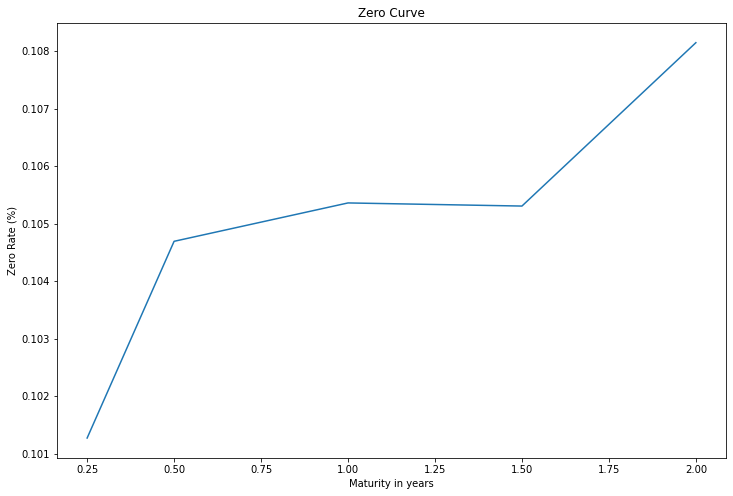

In [4]:
# Instantiate BootstrapYieldCurve

yield_curve = BootstrapYieldCurve()
yield_curve.add_instrument(100, 0.25, 0., 97.5)
yield_curve.add_instrument(100, 0.5, 0., 94.9)
yield_curve.add_instrument(100, 1.0, 0., 90.)
yield_curve.add_instrument(100, 1.5, 8, 96.2, 2)
yield_curve.add_instrument(100, 2.0, 12, 101.6, 2)

y = yield_curve.get_zero_rates()
x = yield_curve.get_maturities()

%pylab inline

fig = plt.figure(figsize=(12,8))
plot(x, y)
title('Zero Curve')
ylabel('Zero Rate (%)')
xlabel('Maturity in years');

In [5]:
# Calculate Forward Rates class to generate list of forward
# rates from a lost of spot rates

In [6]:
class ForwardRates(object):

  def __init__(self):
    self.forward_rates = []
    self.spot_rates = dict()

  def add_spot_rate(self, T, spot_rate):
    self.spot_rates[T] = spot_rate

  def get_forward_rates(self):
    '''
    Returns a list of forward rates
    starting fomr the second time period
    '''
    periods = sorted(self.spot_rates.keys())
    for T2, T1 in zip(periods, periods[1:]):
      forward_rate = self.calculate_forward_rate(T1, T2)
      self.forward_rates.append(forward_rate)

    return self.forward_rates

  def calculate_forward_rate(self, T1, T2):
    R1 = self.spot_rates[T1]
    R2 = self.spot_rates[T2]
    forward_rate = (R2*T2 - R1*T1) / (T2-T1)
    return forward_rate

In [7]:
fr = ForwardRates()
fr.add_spot_rate(0.25, 10.127)
fr.add_spot_rate(0.50, 10.469)
fr.add_spot_rate(1.00, 10.536)
fr.add_spot_rate(1.50, 10.681)
fr.add_spot_rate(2.00, 10.808)

print(fr.get_forward_rates())

[10.810999999999998, 10.603, 10.971, 11.189]


In [8]:
# Calculator: Yield to Maturity

import scipy.optimize as optimize

def bond_ytm(price, par, T, coup, freq=2, guess=0.05):
  freq = float(freq)
  periods = T * 2
  coupon = coup / 100.0 * par
  dt = [(i+1) / freq for i in range(int(periods))]
  ytm_func = lambda y: \
    sum([coupon/freq/(1+y/freq)**(freq*t) for t in dt]) + \
    par / (1+y/freq)**(freq*T) - price

  return optimize.newton(ytm_func, guess)

In [9]:
# Calculating Yield to Maturity

ytm = bond_ytm(95.0428, 100, 1.5, 5.75, 2)
print(ytm)

0.09369155345239477


In [10]:
# Calculator the price of a bond

def bond_price(par, T, ytm, coup, freq=2):
  freq = float(freq)
  periods = T*2
  coupon = coup / 100. * par
  dt = [ (1+i) / freq for i in range(int(periods))]
  price = sum([coupon/freq/(1+ytm/freq) ** (freq*t) for t in dt]) + \
    par / (1+ytm/freq) ** (freq*T)
  return price

In [11]:
# Calculating the price of a bond

price = bond_price(100, 1.5, 0.09369155345239477, 5.75, 2)
print(price)

95.04280000000004


In [12]:
# Calculator for Modified Duration

def bond_mod_duration(price, par, T, coup, freq, dy=0.01):
  ytm = bond_ytm(price, par, T, coup, freq)
  ytm_minus = ytm - dy 
  price_minus = bond_price(par, T, ytm_minus, coup, freq)
  ytm_plus = ytm + dy
  price_plus = bond_price(par, T, ytm_plus, coup, freq)
  mduration = (price_minus - price_plus) /  (2*price*dy)
  return mduration

In [13]:
# Calculating Modified Duration

mod_duration = bond_mod_duration(95.0428, 100, 1.5, 5.75, 2)
print(mod_duration)

1.3921935426560885


In [14]:
# Calculator for Convexity

def bond_convexity(price, par, T, coup, freq, dy=0.01):
  ytm = bond_ytm(price, par, T, coup, freq)
  ytm_minus = ytm - dy
  price_minus = bond_price(par, T, ytm_minus, coup, freq)
  ytm_plus = ytm + dy
  price_plus = bond_price(par, T, ytm_plus, coup, freq)
  convexity = (price_minus + price_plus - 2*price) / (price*dy**2)
  return convexity

In [15]:
# Calculate convexity

convexity = bond_convexity(95.0428, 100, 1.5, 5.75, 2)
print(convexity)

2.6339593903438367


In [18]:
# Vasicek Model

import math
import numpy as np

def vasicek(r0, K, theta, sigma, T=1., N=10, seed=777):
  np.random.seed(seed)
  dt = T/float(N)
  rates = [r0]
  for i in range(N):
    dr = K*(theta-rates[-1])*dt + sigma*math.sqrt(dt)*np.random.normal()
    rates.append(rates[-1]+dr)
  return range(N+1), rates

Populating the interactive namespace from numpy and matplotlib


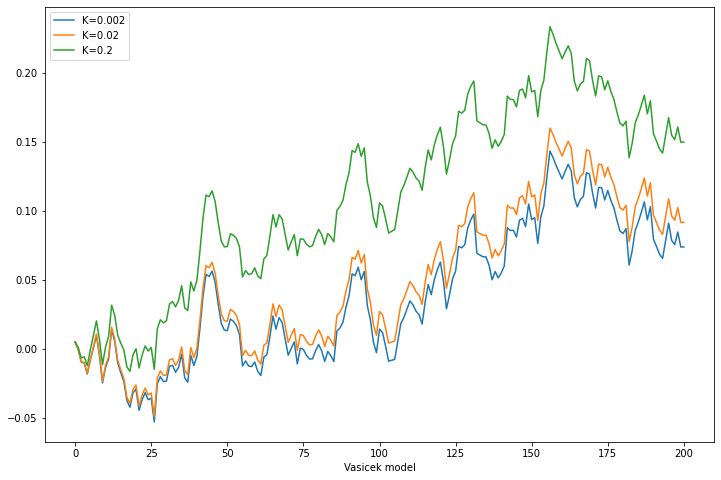

In [35]:
# Create Vasicek simulation

%pylab inline

fig = plt.figure(figsize=(12, 8))
for K in [0.002, 0.02, 0.2]:
  x, y = vasicek(0.005, K, 0.15, 0.05, T=10, N=200)
  plot(x, y, label = 'K=%s'%K)
  pylab.legend(loc = 'upper left');

pylab.legend(loc = 'upper left')
pylab.xlabel('Vasicek model');